In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [67]:
def cargar_datos(ruta_archivo):
    # Carga los datos del archivo CSV
    datos = pd.read_csv(ruta_archivo, delimiter=',')
    return datos
##Se realiza la carga con Pandas ya que numpy no muestra los valores categoricos
if __name__ == "__main__":
    ruta_archivo = '../ejercicios_core/data/retail_sales_dataset.csv'
    df = cargar_datos(ruta_archivo)  
df

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
...,...,...,...,...,...,...,...,...,...
995,996,2023-05-16,CUST996,Male,62,Clothing,1,50,50
996,997,2023-11-17,CUST997,Male,52,Beauty,3,30,90
997,998,2023-10-29,CUST998,Female,23,Beauty,4,25,100
998,999,2023-12-05,CUST999,Female,36,Electronics,3,50,150


## Parte 1: Exploración y Visualización de Datos (EDA)
Carga y Exploración Inicial de Datos:

* Cargar el dataset y revisar su estructura básica.
* Describir las variables y su distribución.
* Identificar y tratar valores nulos y outliers.



In [68]:
##Exploracion de datos
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


,Transaction ID,Age,Quantity,Price per Unit,Total Amount
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,500.500000,41.39200,2.514000,179.890000,456.000000
std,288.819436,13.68143,1.132734,189.681356,559.997632
min,1.000000,18.00000,1.000000,25.000000,25.000000
25%,250.750000,29.00000,1.000000,30.000000,60.000000
50%,500.500000,42.00000,3.000000,50.000000,135.000000
75%,750.250000,53.00000,4.000000,300.000000,900.000000
max,1000.000000,64.00000,4.000000,500.000000,2000.000000


In [69]:
# Identificar valores faltantes
def identificar_valores_faltantes(df):
    print("Valores faltantes en el dataset")
    qsna = df.shape[0] - df.isnull().sum(axis=0)
    qna = df.isnull().sum(axis=0)
    ppna = round(100 * (df.isnull().sum(axis=0) / df.shape[0]), 2)

    # Crear DataFrame con los resultados
    aux = {'datos sin NAs en q': qsna, 'Na en q': qna, 'Na en %': ppna}
    na_df = pd.DataFrame(data=aux)

    # Ordenar el DataFrame por el porcentaje de valores faltantes
    return na_df.sort_values(by='Na en %', ascending=False)

na_df = identificar_valores_faltantes(df)
print(na_df)

###No existen valores nulos

##Verificacion de elementos duplicados
###
print("Cantidad de filas duplicadas: ",df.duplicated().sum())
###No se verifican valores duplicados
##Se elimina columnas de id que no tiene valor significativo para la prediccion
df = df.drop(columns=['Transaction ID','Customer ID'])  

# Convertir la columna 'date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extraer características temporales
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df = df.drop(columns=['Date'])
df[['Year', 'Month', 'Day']] = df[['Year', 'Month', 'Day']].astype('Int64')
print(df.head())

Valores faltantes en el dataset
                  datos sin NAs en q  Na en q  Na en %
Transaction ID                  1000        0      0.0
Date                            1000        0      0.0
Customer ID                     1000        0      0.0
Gender                          1000        0      0.0
Age                             1000        0      0.0
Product Category                1000        0      0.0
Quantity                        1000        0      0.0
Price per Unit                  1000        0      0.0
Total Amount                    1000        0      0.0
Cantidad de filas duplicadas:  0
   Gender  Age Product Category  Quantity  Price per Unit  Total Amount  Year  \
0    Male   34           Beauty         3              50           150  2023   
1  Female   26         Clothing         2             500          1000  2023   
2    Male   50      Electronics         1              30            30  2023   
3    Male   37         Clothing         1             500    

In [70]:
### Verificar inconsistencias
#### Verificacion de inconsistencias en datos categoricos
def contar_valores_categoricos(df):
    # Recorre las columnas categóricas del DataFrame
    for col in df.select_dtypes(include=['object', 'category']):
        print(f'Valores únicos en la columna: {col}')
        print(df[col].value_counts())
        print('-' * 50)

##Se cambiar str to upper y strip utilizando metodo apply.
def modificar_valores_categoricos(df):
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].str.upper().str.strip()
    return df
print(contar_valores_categoricos(df))
df = modificar_valores_categoricos(df)
print(df.head())

Valores únicos en la columna: Gender
Gender
Female    510
Male      490
Name: count, dtype: int64
--------------------------------------------------
Valores únicos en la columna: Product Category
Product Category
Clothing       351
Electronics    342
Beauty         307
Name: count, dtype: int64
--------------------------------------------------
None
   Gender  Age Product Category  Quantity  Price per Unit  Total Amount  Year  \
0    MALE   34           BEAUTY         3              50           150  2023   
1  FEMALE   26         CLOTHING         2             500          1000  2023   
2    MALE   50      ELECTRONICS         1              30            30  2023   
3    MALE   37         CLOTHING         1             500           500  2023   
4    MALE   30           BEAUTY         2              50           100  2023   

   Month  Day  
0     11   24  
1      2   27  
2      1   13  
3      5   21  
4      5    6  


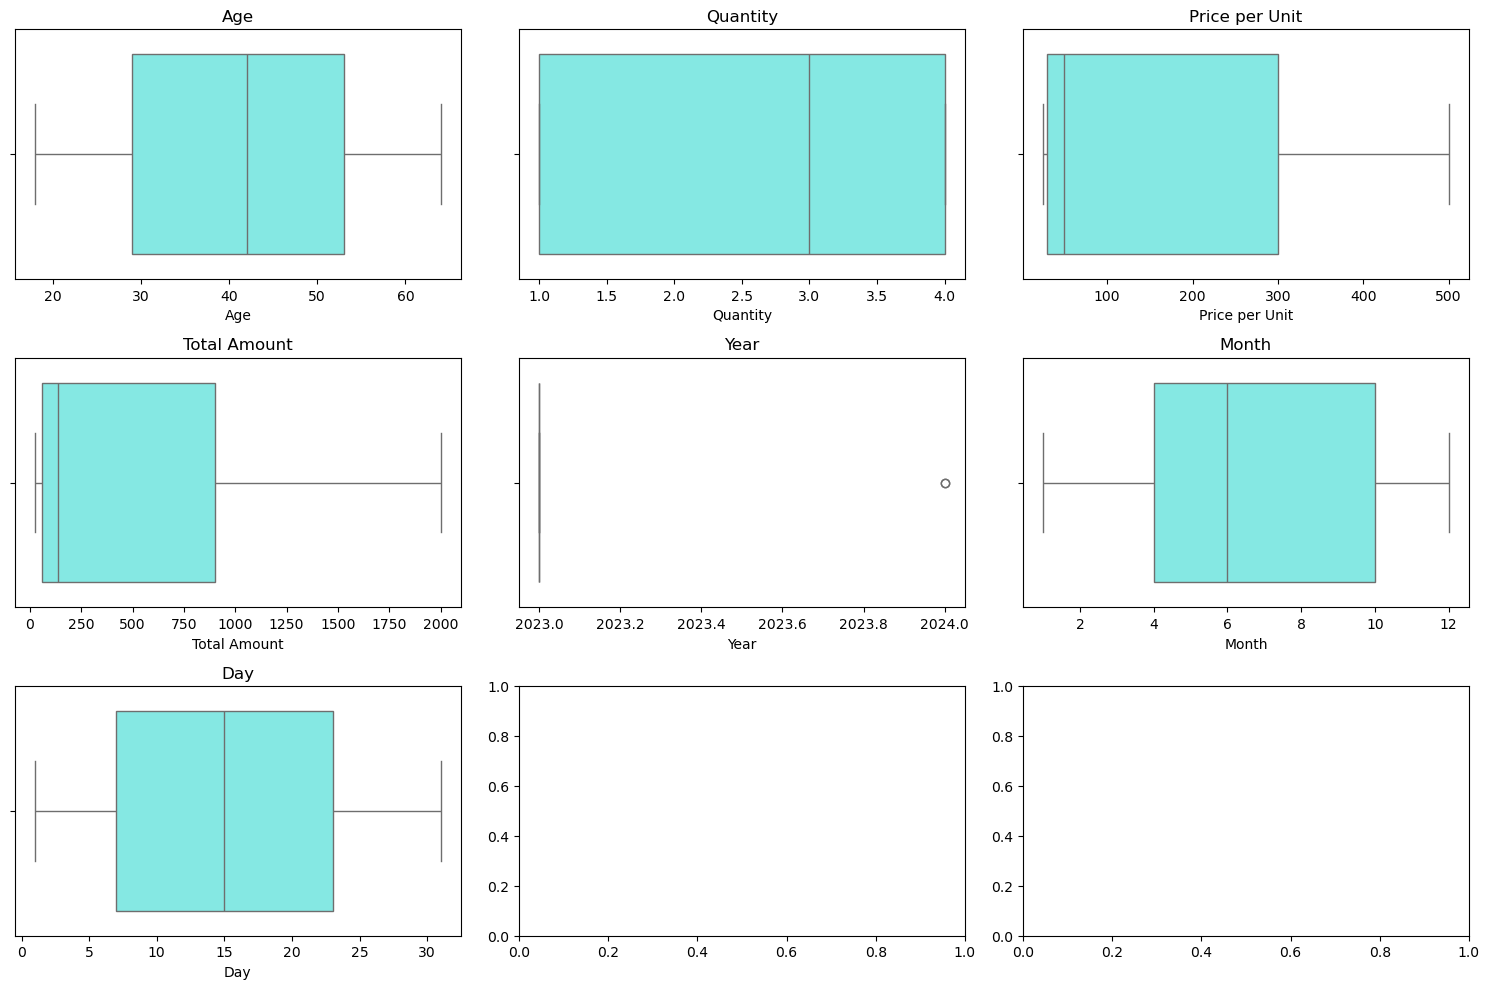

In [72]:
### Verificacion de outliers
num_features = df.select_dtypes(include=['int64', 'float64'])
def plot_grafico_outliers(num_features, df):

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

    for i, feature in enumerate(num_features):
        row, col = divmod(i, 3)
        sns.boxplot(x=df[feature], ax=axes[row, col], color="#75f8f2")
        axes[row, col].set_title(feature)

    plt.tight_layout()
    plt.show()
plot_grafico_outliers(num_features,df)

##### No se visualiza outliers, los datos no se ven compactos para Age, Quantity, sin embargo Price per unit y Total amount se verifica altas dispersiones. 

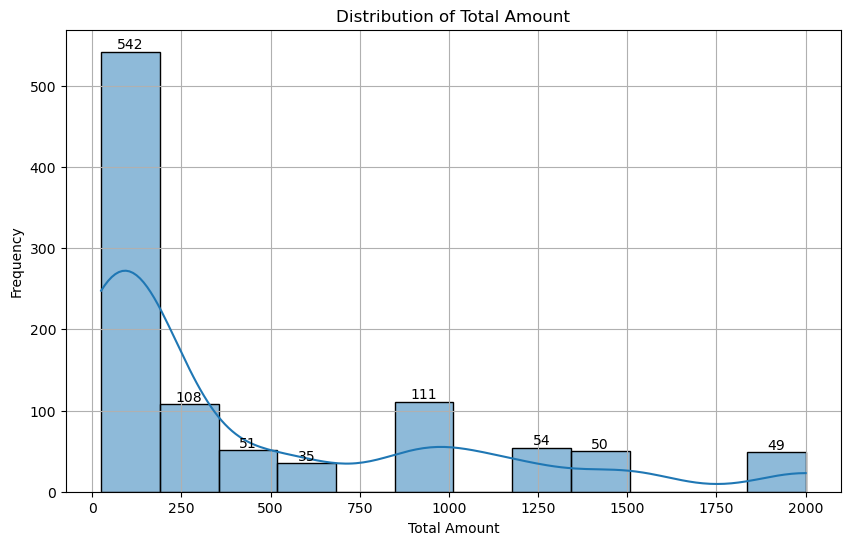

In [73]:
## Exploracion de datos
# Distribucion de Total Amount
plt.figure(figsize=(10, 6))
# Crear el histograma y almacenar la salida en una variable
hist = sns.histplot(df['Total Amount'], kde=True)
# Agregar los valores encima de las barras
for patch in hist.patches:  # Iterar sobre las barras
    x = patch.get_x() + patch.get_width() / 2  # Centro de la barra
    y = patch.get_height()  # Altura de la barra
    if y > 0:  # Mostrar solo si la frecuencia no es cero
        plt.text(x, y, int(y), ha='center', va='bottom', fontsize=10)
plt.title('Distribution of Total Amount')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.grid()
plt.show()

##### En este grafico se ve que los datos estan mas segados a montos pequenhos entre 0 y 250, tambien se ven un pico de montos entre aproximadamente 800 a 1000 lo que indicaria un dato importante a anlizarse.

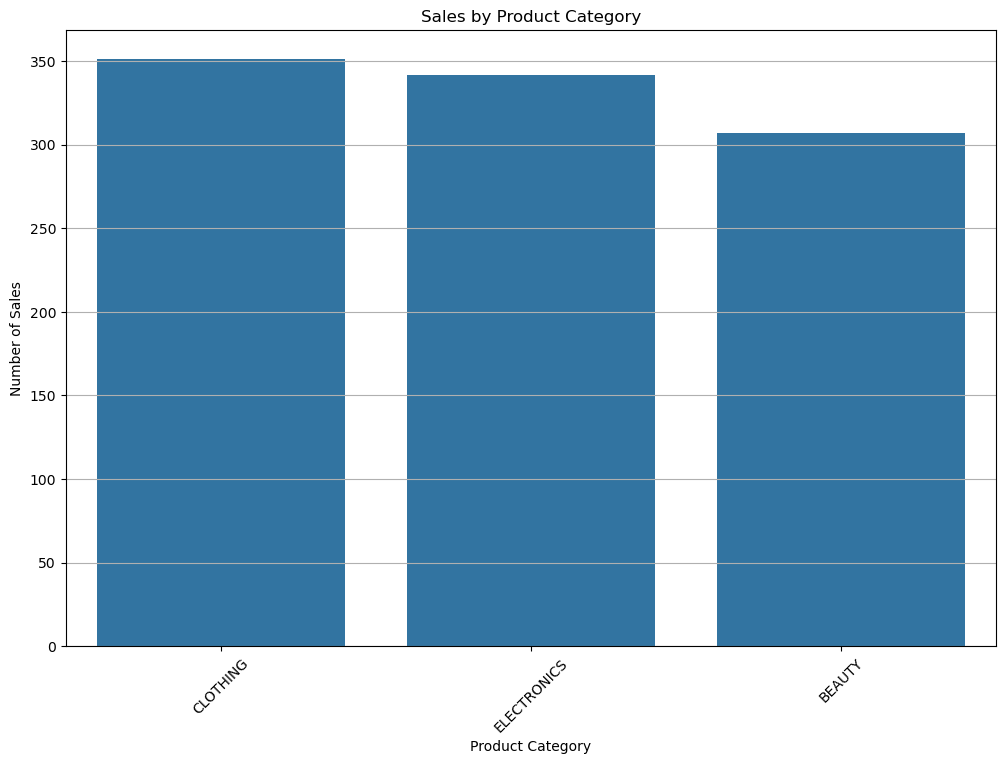

In [74]:
# Sales by Product Category
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Product Category', order=df['Product Category'].value_counts().index)
plt.title('Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.grid(axis = 'y')
plt.show()

##### El grafico muestra que la mayor cantidad de ventas la tiene la categoria de clothing con 350 ventas, seguido de electronics con aproximadamente 340 y finalmente Beauty con 310 aproximadamente de ventas.

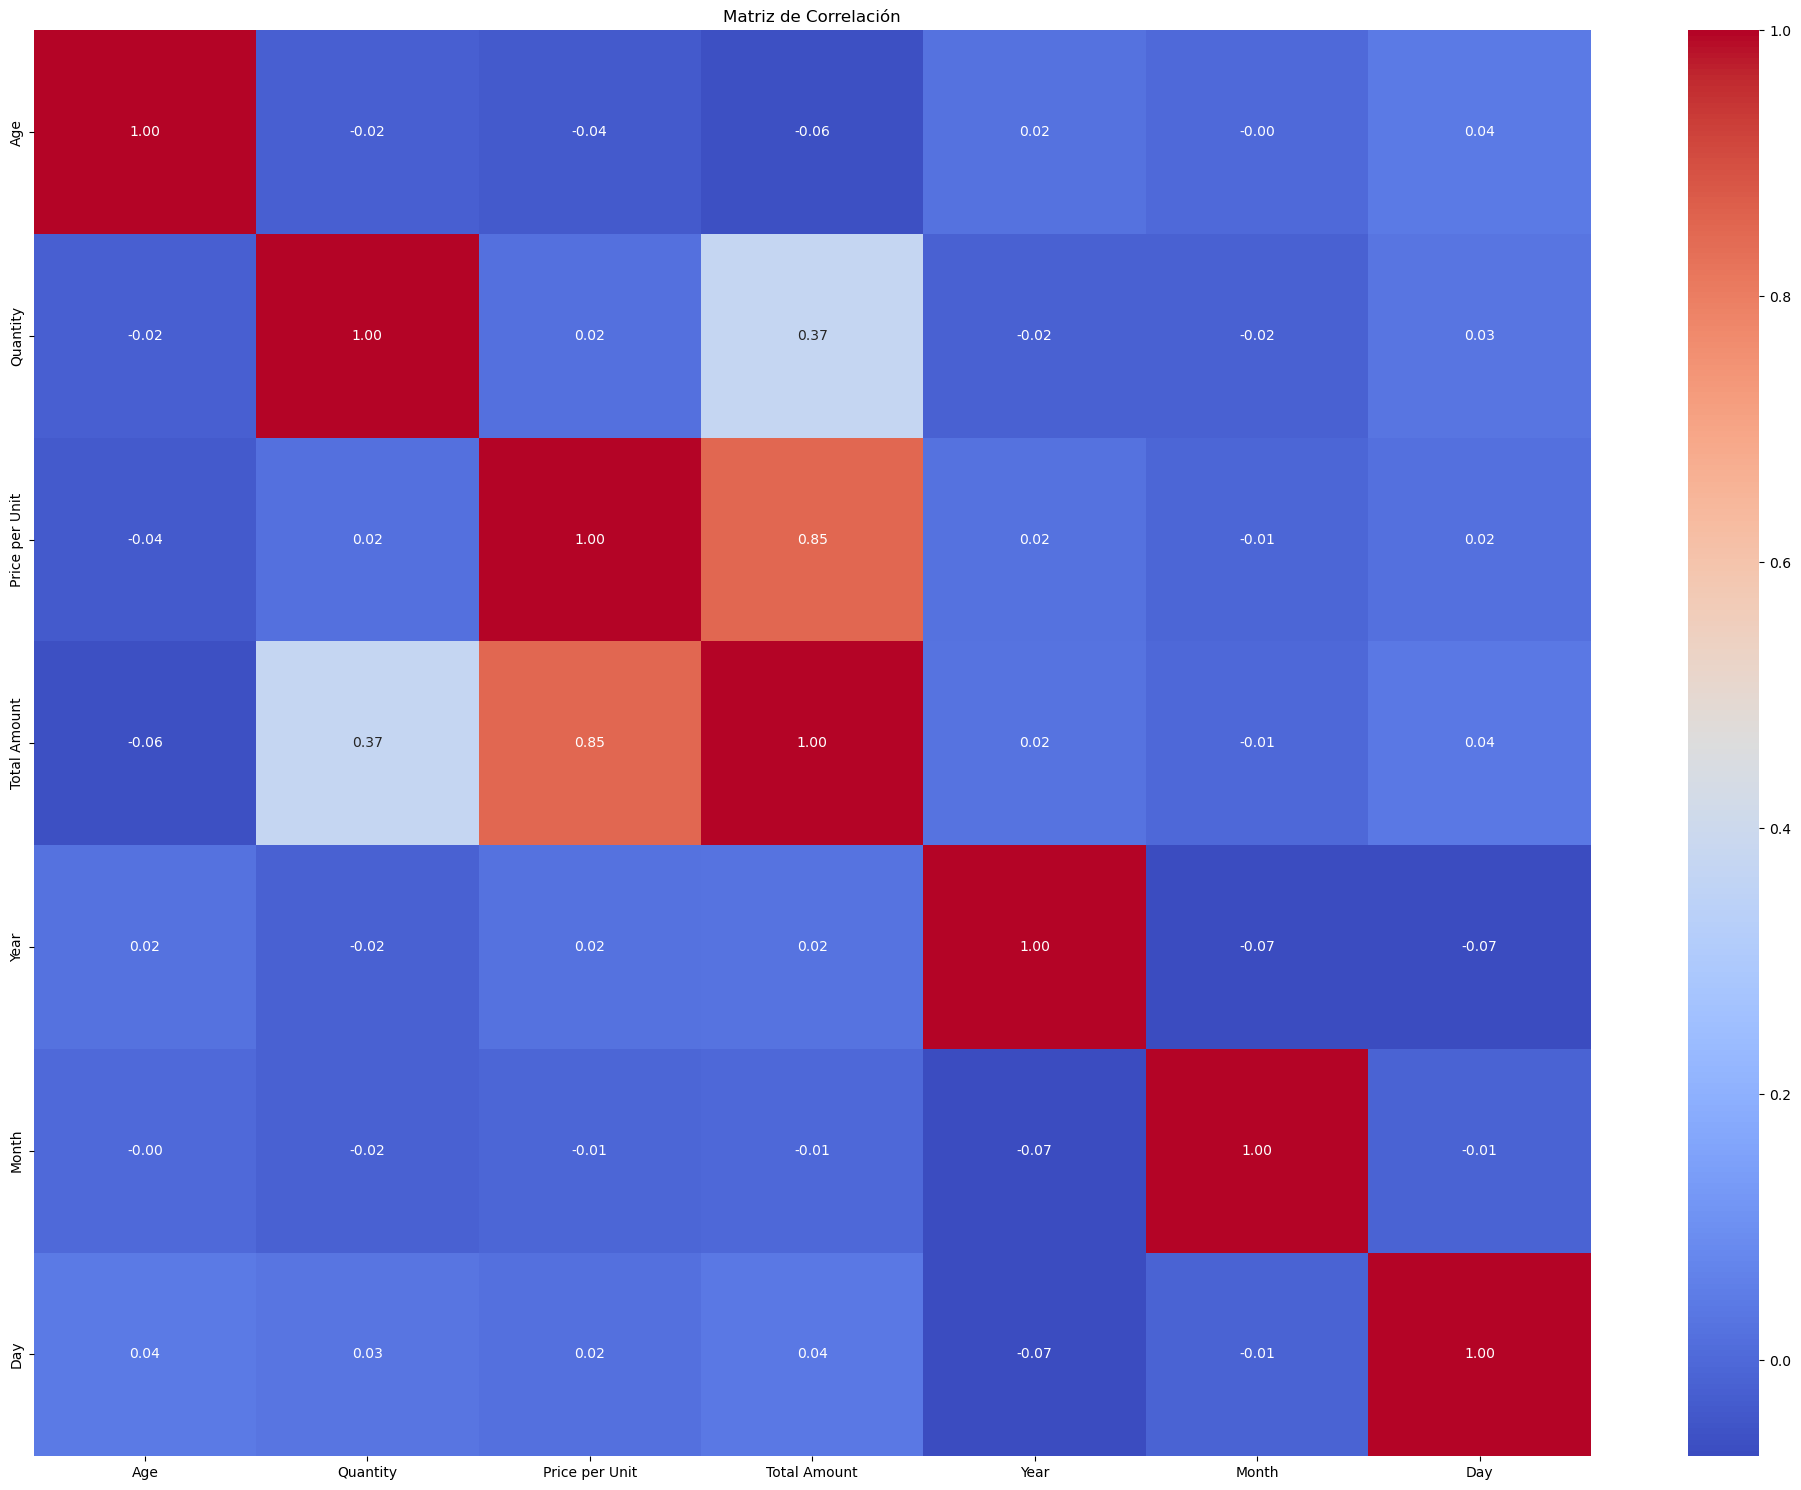

In [75]:
# Mapa de calor para la correlación entre variables numéricas
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
plt.figure(figsize=(20, 15))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

##### Para nuestro target en este caso Total Amount, el price per unit es la variable mas alta con 0.85 de correlacion, seguido de quanty con 0.37, la edad, day, month y year no se ven que tengan relacion con total amount

In [92]:
# Calcular medidas de tendencia central y dispersión para cada variable numérica
measures = {}

for column in df.select_dtypes(include=[float, int]).columns:
    measures[column] = {
        'Mean': df[column].mean(),
        'Median': df[column].median(),
        'Mode': df[column].mode()[0],
        'Std Dev': df[column].std(),
        'Range': df[column].max() - df[column].min()
    }

# Mostrar medidas de tendencia central y dispersión
for column, stats in measures.items():
    print(f"\n{column}:")
    for measure, value in stats.items():
        print(f"  {measure}: {value}")


Age:
  Mean: 41.392
  Median: 42.0
  Mode: 43
  Std Dev: 13.681429659122532
  Range: 46

Quantity:
  Mean: 2.514
  Median: 3.0
  Mode: 4
  Std Dev: 1.1327343409145405
  Range: 3

Price per Unit:
  Mean: 179.89
  Median: 50.0
  Mode: 50
  Std Dev: 189.68135627129138
  Range: 475

Total Amount:
  Mean: 456.0
  Median: 135.0
  Mode: 50
  Std Dev: 559.997631555123
  Range: 1975

Year:
  Mean: 2023.002
  Median: 2023.0
  Mode: 2023
  Std Dev: 0.044698970882985634
  Range: 1

Month:
  Mean: 6.549
  Median: 6.0
  Mode: 5
  Std Dev: 3.452755496776527
  Range: 11

Day:
  Mean: 15.31
  Median: 15.0
  Mode: 5
  Std Dev: 8.871674397012471
  Range: 30


### Parte 2: Preprocesamiento de Datos

1. Transformación de Columnas:
    * Utilizar ColumnTransformer para aplicar transformaciones específicas a diferentes columnas.
    * Realizar codificación de variables categóricas y escalado de variables numéricas.
2. Pipelines:
    * Crear pipelines para automatizar el preprocesamiento de datos y asegurar la reproducibilidad.


In [76]:
# Definir X e y. Dividir los datos en conjunto de entrenamiento y prueba

X = df.drop(['Total Amount'], axis=1)
y = df['Total Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [77]:
###Pipeline para preprocesamiento de valores
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get column names
categorical_features = X.select_dtypes(include=['object']).columns.tolist() # Get column names
# Crear transformadores para cada subconjunto de columnas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Colocar nombres como strings
    ('scaler', StandardScaler())
])

# Crear transformer para columnas categóricas con imputación
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes con el mas frecuente (moda)
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar categorías
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Integrar en un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Crear y aplicar el pipeline a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train)

# Aplicar la misma transformación a los datos de prueba (sin hacer fit)
X_test_transformed = pipeline.transform(X_test)

print("Preprocesamiento completado. Datos transformados listos para modelar.")

Preprocesamiento completado. Datos transformados listos para modelar.


## Parte 3: Benchmarking de Técnicas de Machine Learning

1. Selección de Modelos:
* Entrenar y evaluar múltiples modelos de machine learning (por ejemplo, Regresión Lineal, KNN, Árbol de Decisión, Random Forest, XGBoost y LGBM).
* Utilizar validación cruzada para evaluar el rendimiento de los modelos.
2. Comparación de Modelos:
* Comparar los modelos utilizando métricas de rendimiento como exactitud, precisión, recall, F1-Score y ROC-AUC.
* Seleccionar el mejor modelo basado en las métricas obtenidas.


##### Debido a que este es un problema de regresion ya que lo que se esta trantando de predecir es el total de ventas, se utilizara modelos lineales como LinearRegresion, DecitionTreeRegresor y KnnRegression. Y se utilizaran las metricas correspondientes. 

In [90]:
# Crear los modelos
modelo_lr = LinearRegression()
modelo_knn = KNeighborsRegressor(n_neighbors=5)
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Evaluación con validación cruzada (usando R² como métrica)
# Puedes cambiar el parámetro 'scoring' para obtener MSE, RMSE, etc.
r2_lr = cross_val_score(modelo_lr, X_train_transformed, y_train, cv=5, scoring='r2')
r2_knn = cross_val_score(modelo_knn, X_train_transformed, y_train, cv=5, scoring='r2')
r2_rf = cross_val_score(modelo_rf, X_train_transformed, y_train, cv=5, scoring='r2')

# Imprimir resultados de la validación cruzada
print(f'R² Promedio Regresión Lineal: {r2_lr.mean()}')
print(f'R² Promedio KNN: {r2_knn.mean()}')
print(f'R² Promedio Random Forest: {r2_rf.mean()}')

# Si deseas obtener también MSE o RMSE, puedes hacer algo como esto:
mse_lr = cross_val_score(modelo_lr, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error')
mse_knn = cross_val_score(modelo_knn, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error')
mse_rf = cross_val_score(modelo_rf, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error')

print(f'MSE Promedio Regresión Lineal: {-mse_lr.mean()}')
print(f'MSE Promedio KNN: {-mse_knn.mean()}')
print(f'MSE Promedio Random Forest: {-mse_rf.mean()}')

# Si quieres calcular RMSE a partir de MSE:
rmse_lr = np.sqrt(-mse_lr.mean())
rmse_knn = np.sqrt(-mse_knn.mean())
rmse_rf = np.sqrt(-mse_rf.mean())

print(f'RMSE Promedio Regresión Lineal: {rmse_lr}')
print(f'RMSE Promedio KNN: {rmse_knn}')
print(f'RMSE Promedio Random Forest: {rmse_rf}')


R² Promedio Regresión Lineal: 0.8500375351441658
R² Promedio KNN: 0.9251154001622643
R² Promedio Random Forest: 1.0
MSE Promedio Regresión Lineal: 46302.92699903973
MSE Promedio KNN: 23425.425
MSE Promedio Random Forest: -0.0
RMSE Promedio Regresión Lineal: 215.1811492650779
RMSE Promedio KNN: 153.05366705832304
RMSE Promedio Random Forest: -0.0


Text(0, 0.5, 'Valor de R²')

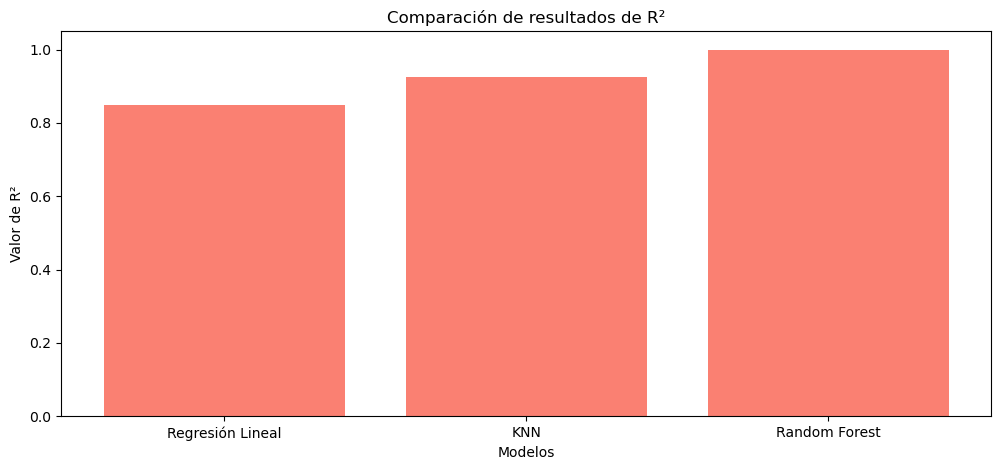

In [91]:
# Promediar los valores de R² de la validación cruzada
mean_r2_lr = r2_lr.mean()
mean_r2_knn = r2_knn.mean()
mean_r2_rf = r2_rf.mean()

# Nombres de los modelos
model_names = ['Regresión Lineal', 'KNN', 'Random Forest']
# Promedios de R² de cada modelo
r2_values = [mean_r2_lr, mean_r2_knn, mean_r2_rf]

# Crear la figura
fig = plt.figure(figsize=(12, 5))

# Agregar un subgráfico (axes) a la figura
ax = fig.add_subplot(111)  # 111 significa 1 fila, 1 columna, primer subgráfico

# Gráfico de barras para R²
ax.bar(model_names, r2_values, color='salmon')
ax.set_title('Comparación de resultados de R²')
ax.set_xlabel('Modelos')
ax.set_ylabel('Valor de R²')

##### Como se puede observar, para este problema de regresion el Random Forest tuvo un resultado excelente en el entrenamiento, seguido de KNN y Regresion Lineal. 